### Problem Statement

Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

In [1]:
# Importing required packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#### Load the data: the Cats vs Dogs dataset

You can download dataset [here](https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip)

**Filter out corrupted images**

When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string `JFIF` in their header.

In [2]:
import os

num_skipped = 0
for folder_name in ['Cat', 'Dog']:
    folder_path = os.path.join('PetImages', folder_name)
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        try:
            image_obj = open(image_path, 'rb')
            is_jfif = tf.compat.as_bytes('JFIF') in image_obj.peek(10)
        finally:
            image_obj.close()
            
        if not is_jfif:
            num_skipped += 1
            
            # delete corrupted image
            os.remove(image_path)
            
print(f'deleted {num_skipped} images')

deleted 1578 images


### Generate a Dataset

In [3]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'PetImages',
    validation_split=0.2,
    subset='training',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'PetImages',
    validation_split=0.2,
    subset='validation',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


### Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is `dog` and label 0 is `cat`.

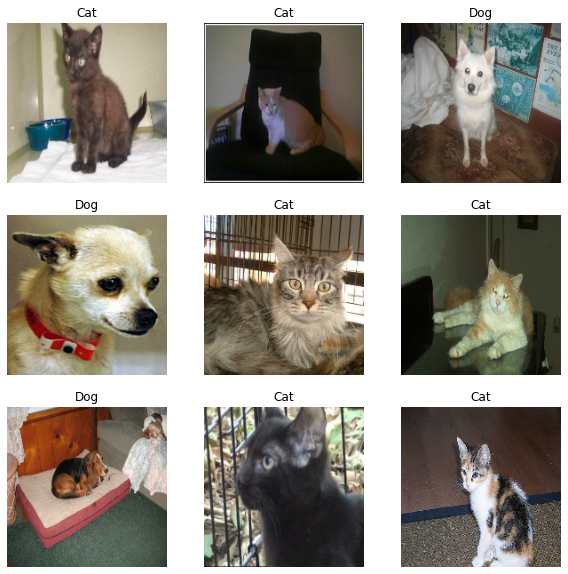

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title('Cat' if int(labels[i])==0 else 'Dog')
        plt.axis('off')

### Using image data augmentation

When we don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [11]:
data_agumentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1)
    ]
)

Let's visualize what the augmented samples look like, by applying `data_augmentation` repeatedly to the first image in the dataset

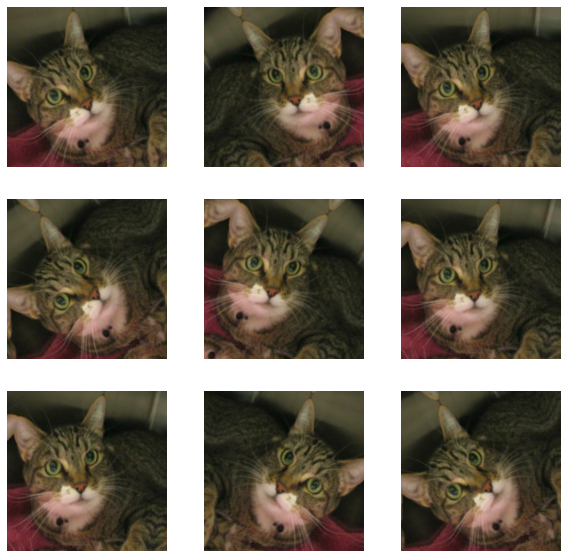

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

### Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general we should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.

---

### Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

In [7]:
# inputs = keras.Input(shape=input_shape)
# x = data_augmentation(inputs)
# x = layers.Rescaling(1./255)(x)
# # Rest of the model

With this option, our data augmentation will happen on device, synchronously with the rest of the model execution, meaning that it will benefit from GPU acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be augmented during fit(), not when calling evaluate() or predict().

If you're training on GPU, this is the better option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of augmented images, like this:

In [8]:
# augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

With this option, your data augmentation will happen on CPU, asynchronously, and will be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation asynchronous and non-blocking.

In our case, we'll go with the first option.


---

### Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [9]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

### Build a model

We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using KerasTuner.

Note that:
* We start the model with the `data_augmentation` preprocessor, followed by a `Rescaling` layer.
* We include a `Dropout` layer before the final classification layer.

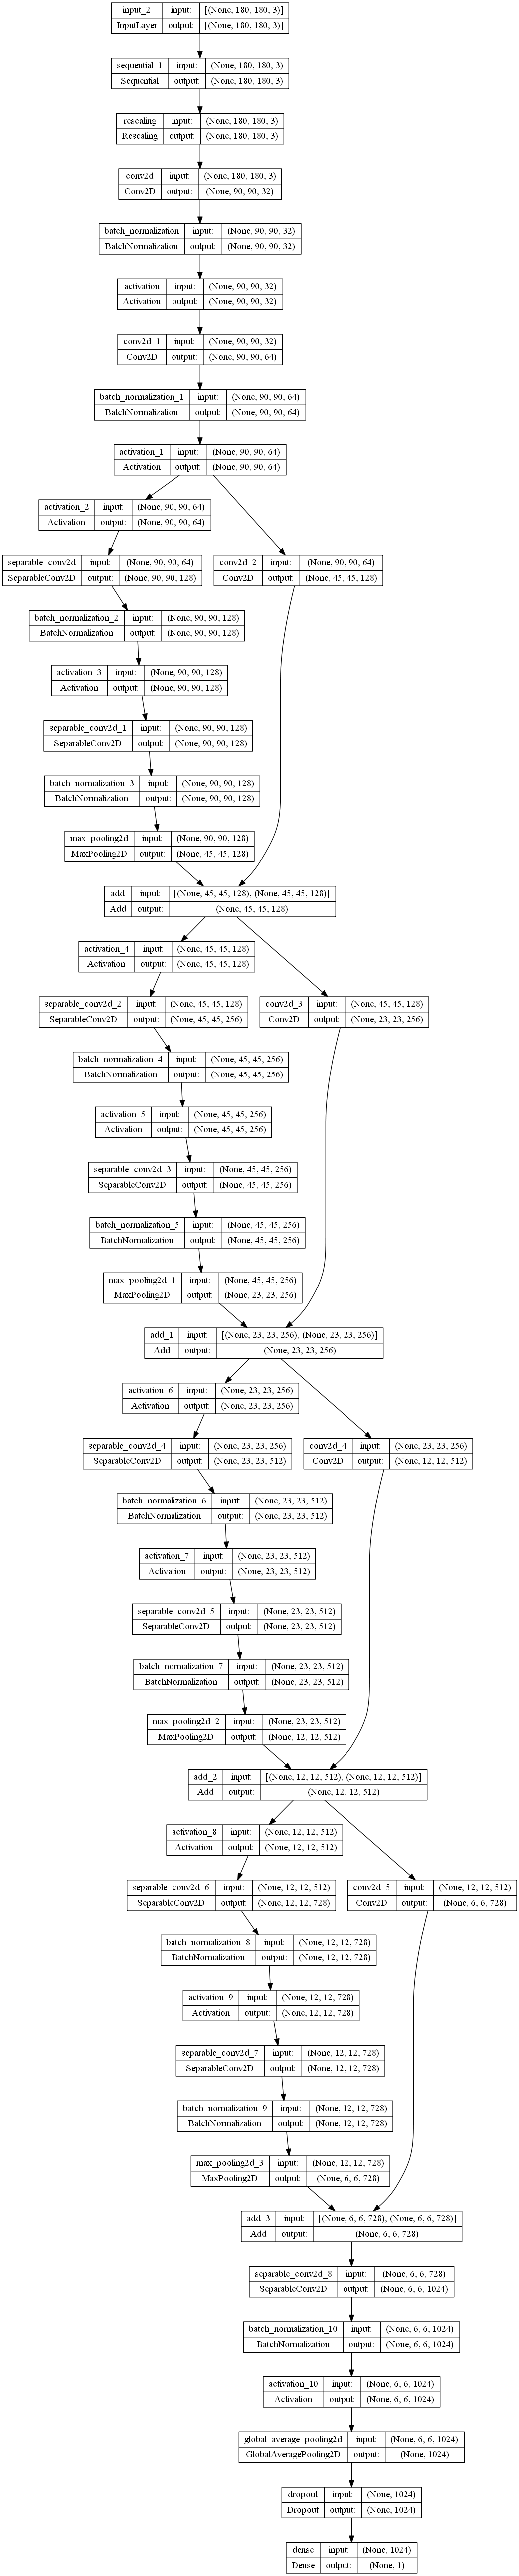

In [12]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    # image agumentation block
    x = data_agumentation(inputs)
    
    # entry block
    x = layers.Rescaling(1.0/255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    previous_block_activation = x # set aside residual
    
    for size in [128, 256, 512, 728]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPool2D(3, strides=2, padding='same')(x)
        
        # project residual
        residual = layers.Conv2D(size, 1, strides=2, padding='same')(
            previous_block_activation
        )
        x = layers.add([x, residual]) # add back residual
        previous_block_activation = x # set aside next residual
        
    x = layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
        
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

### Train the model

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint('save_at_{epoch}.h5')
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds
)

Epoch 1/50
586/586 [==============================] - 1335s 2s/step - loss: 0.4632 - accuracy: 0.7838 - val_loss: 0.4139 - val_accuracy: 0.8132
Epoch 2/50
586/586 [==============================] - 1368s 2s/step - loss: 0.3734 - accuracy: 0.8361 - val_loss: 0.3540 - val_accuracy: 0.8416
Epoch 3/50
586/586 [==============================] - 1466s 3s/step - loss: 0.3045 - accuracy: 0.8703 - val_loss: 0.5705 - val_accuracy: 0.7910
Epoch 4/50
586/586 [==============================] - 1338s 2s/step - loss: 0.2590 - accuracy: 0.8921 - val_loss: 0.5459 - val_accuracy: 0.7812
Epoch 5/50
586/586 [==============================] - 1363s 2s/step - loss: 0.2268 - accuracy: 0.9043 - val_loss: 0.3973 - val_accuracy: 0.8456
Epoch 6/50
586/586 [==============================] - 1331s 2s/step - loss: 0.2007 - accuracy: 0.9183 - val_loss: 0.1901 - val_accuracy: 0.9251
Epoch 7/50
586/586 [==============================] - 1302s 2s/step - loss: 0.1890 - accuracy: 0.9230 - val_loss: 0.1781 - val_accuracy:

### Run inference on new data

Note that data augmentation and dropout are inactive at inference time.

In [ ]:
img = keras.preprocessing.image.load_img(
    'PetImages/Cat/152.jpg', target_size=image_size
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)